<a href="https://colab.research.google.com/github/JerrodW1/CIS9650-Term-Project-Starter/blob/main/Group_14_Term_Project_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Healthcare Providers in New York State

## Authors: Catalina , Mahisa , Jerrod W, Dhawanika


## Date: December 10, 2025

# Executive Summary

This project analyzes primary care physician data across New York State in order to understand provider quality rating, patient satisfaction, and geographic trends in healthcare access. After the team has cleaned the dataset, we performed descriptive and visual analysis across specialties, ratings, review volumes, and ZIP codes. Our findings show that most physicians maintain high ratings, and convenient location across specialties. As healthcare consumers increasingly rely on online reviews to choose providers, understanding patterns in physician ratings, geographic trends, and specialty performance has practical value for both patients and healthcare administrators.

Our analysis focuses on three core questions:
1. How do physician ratings vary across specialties and geographic regions?
2. What is the relationship between the amount of reviews and physician rating?
3. Which cities or ZIP codes show the highest concentration of highly rated physicians?

By cleaning this data, we have generated descriptive statistics and visualized patterns across the state. These findings can help patients make better decisions and help medical facilities pinpoint locations where their services and accessibility can be further enhanced.

In addition, we examined the availability of services through remote video visits by analyzing the availability of telehealth services based on ZIP code location. We created additional columns, such as indicators of whether a provider offers telehealth services and a generated email address for contacting them, to provide us with a clearer view of our data and assist in recognizing trends and areas where additional support is needed in providing access to healthcare services.

In [ ]:
#deadline for analysis: Saturday
#highest-rated doctors: nika   UPDATE: doctors with the most reviews instead of highest rated - DONE jerrod
#offers telehealth vs doesnt:  DONE mahisa
#How convienent it is in terms of location / which zip code has the highest average. "whose most healthiest" : Jerrod
#Listing them in alphabetical order: cat
#emails - DONE mahisa
#cleaning "city-state" column - (not really necessary) DONE
#cleaning rating into integer system - floats? -DONE


#next meeting: finalizing code and beginning on visuals


#11/30 meeting:
#histogram for ratings - jerrod - done
#reviews isolated/grouping by zip code -jerrod - done
#'geo-coding data' pinpointing top ten doctors. -cat  DONE(to a certain extent)
#bar chart for telehealth vs none -cat  DONE
#comparing strengths to highest reviews, whats common among the top ten doctors and their strengths -jerrod - in progress
#sorting through the specalities, is it only family medicine. -cat DONE
#bar chart for specialities -cat
#histogram & scatterplot for zip codes - jerrod (NYS only) done


#edit the executive summary - Mahisa


#12/05:
#- #Work on presentation script
#- #Section Headers
#- #Peer Evaluation
#- #Edit executive summary
#- #Describe our visuals
##- #Problem statement/thesis statement
#- #test code

#next meeting:
#

#ask how hes running code &&  is there a template for peer evaluations or do we write on the collab docs?

# Table of Contents

1. Introduction
2. Dataset Overview
3. Analytical objectives
4. Data loading
5. Data cleaning & preparation
6. Exploratory data analysis
7. Data Visualization
8. Insights/results
9. Team contribution
10. References

# Setup and Environment

In [ ]:
#Libraries
import gcsfs
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
#reading files, and extracting data.. Gotta figure out how to collab on Juptyer.
#accessed profs cloud storage with all files, and listing all the files inside
#his folder. Then creating an empty list that will hold all the records from each
#.json file combined together. Inside the for loop, I read each file and loaded the content
#inside in a python object (list or dict). If the file contains a single dict then
# add that dict to the lsit as one item. If the file is not a list or dict, the system warns us.
# - Cat


fs = gcsfs.GCSFileSystem(token="anon") ##connects to profs google cloud storage anon means no password needed

folder = "msba-online-data/CIS9650/Project 02/"
fs.ls(folder)



all_records = []

for fpath in fs.ls(folder):
    if fpath.endswith(".json"):
        with fs.open(fpath, "r") as f:
            obj = json.load(f)

            # If file contains a list of records
            if isinstance(obj, list):
                all_records.extend(obj)

            # If file contains ONE dict
            elif isinstance(obj, dict):
                all_records.append(obj)

            else:
                print("Unknown format:", fpath)

df = pd.json_normalize(all_records)
df.head()

# so far we have name, specialty, rating, reviews, street_address, city_state, profile_link, strengths, attributes
# now we have to "clean" the data
# i was thinking (for example), we could clean the review column into numeric results. like " with\n(5 ratings)" needs to be cleaned to 5 ratings. (integer)
#we could also clean the strengths column to have it list out the number of strengths or something.

#after we clean the data, we should do analysis on each section. For instance, "most common specialities", or "highest-rated doctor"

,name,specialty,rating,reviews,street_address,city_state,profile_link,strengths,attributes
0,"Dr. Rosemary Deleo, MD",Family Medicine,4.7,", with\n(22 ratings)",4 Deleo Dr,"Kerhonkson, NY 12446",https://www.healthgrades.com/physician/dr-rose...,[Listened/answered questions (21) | Explains c...,[Offers Telehealth]
1,"Dr. Bipin Bhavsar, MD",Family Medicine,NA,Leave A Review,5 Ridgeview Rd,"Kerhonkson, NY 12446",https://www.healthgrades.com/physician/dr-bipi...,[],[]
2,"Dr. Devon Craft, DO",Family Medicine,2.6,", with\n(5 ratings)",6743 Route 209,"Kerhonkson, NY 12446",https://www.healthgrades.com/physician/dr-devo...,[],[Offers Telehealth]
3,"Dr. Elizabeth Gregory, MD",Family Medicine,3.5,", with\n(6 ratings)",10 Gagnon Dr Ste 209,"Stone Ridge, NY 12484",https://www.healthgrades.com/physician/dr-eliz...,[Explains conditions well (5) | Found trustwor...,[]
4,"Dr. Robert Taylor, MD",Family Medicine,3.5,", with\n(8 ratings)",10 Gagnon Dr,"Stone Ridge, NY 12484",https://www.healthgrades.com/physician/dr-robe...,[Listened/answered questions (5)],[]


In [30]:
# Re-initialize df to ensure 'reviews' column is present before cleaning

# Ensure the 'reviews' column is treated as strings to avoid AttributeError
df['reviews'] = df['reviews'].astype(str)

# Replace 'NA' and 'Leave A Review' with NaN for easier numerical processing
df['reviews'] = df['reviews'].replace({'NA': np.nan, 'Leave A Review': np.nan})

# Extract only the numerical part from the reviews string using a raw string for the regex
# This regex looks for one or more digits (\d+) and captures them.
# It also handles cases like ', with(5 ratings)' by just taking the number.
df['review_count'] = df['reviews'].str.extract(r'(\d+)').astype(float)

# Drop the original 'reviews' column if it's no longer needed
df = df.drop(columns=['reviews'])

print(df.head())

                        name        specialty rating        street_address  \
0     Dr. Rosemary Deleo, MD  Family Medicine    4.7            4 Deleo Dr   
1      Dr. Bipin Bhavsar, MD  Family Medicine     NA        5 Ridgeview Rd   
2        Dr. Devon Craft, DO  Family Medicine    2.6        6743 Route 209   
3  Dr. Elizabeth Gregory, MD  Family Medicine    3.5  10 Gagnon Dr Ste 209   
4      Dr. Robert Taylor, MD  Family Medicine    3.5          10 Gagnon Dr   

              city_state                                       profile_link  \
0   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-rose...   
1   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-bipi...   
2   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-devo...   
3  Stone Ridge, NY 12484  https://www.healthgrades.com/physician/dr-eliz...   
4  Stone Ridge, NY 12484  https://www.healthgrades.com/physician/dr-robe...   

                                           strengths    

In [31]:
#Seperates zip code from string - Jerrod
df2 = df['city_state'].str.extract(r'^(?P<cities>.*)\s+(?P<zip_code>\d{5})$').map(str.strip)

#Removes the comma and NY with an empty string
df2["cities"] = df2['cities'].str.replace(", NY", '')
print(df2.head())

        cities zip_code
0   Kerhonkson    12446
1   Kerhonkson    12446
2   Kerhonkson    12446
3  Stone Ridge    12484
4  Stone Ridge    12484


In [32]:
# Extract city and zip code from 'city_state' column
df2 = df['city_state'].str.extract(r'^(?P<cities>.*)\s+(?P<zip_code>\d{5})$').map(str.strip)
df2["cities"] = df2['cities'].str.replace(", NY", '')

# Concatenate df2 with df to add 'cities' and 'zip_code' columns to df
df = pd.concat([df, df2], axis=1)

# Convert 'zip_code' to integer type
df['zip_code'] = df['zip_code'].astype(int)

ny_zip_min = 10001
ny_zip_max = 14999

df_ny = df[(df['zip_code'] >= ny_zip_min) & (df['zip_code'] <= ny_zip_max)].copy()

print(f"Original number of records: {len(df)}")
print(f"Number of records after filtering for NY zip codes: {len(df_ny)}")
print(df_ny.head())

Original number of records: 62846
Number of records after filtering for NY zip codes: 62671
                        name        specialty rating        street_address  \
0     Dr. Rosemary Deleo, MD  Family Medicine    4.7            4 Deleo Dr   
1      Dr. Bipin Bhavsar, MD  Family Medicine     NA        5 Ridgeview Rd   
2        Dr. Devon Craft, DO  Family Medicine    2.6        6743 Route 209   
3  Dr. Elizabeth Gregory, MD  Family Medicine    3.5  10 Gagnon Dr Ste 209   
4      Dr. Robert Taylor, MD  Family Medicine    3.5          10 Gagnon Dr   

              city_state                                       profile_link  \
0   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-rose...   
1   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-bipi...   
2   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-devo...   
3  Stone Ridge, NY 12484  https://www.healthgrades.com/physician/dr-eliz...   
4  Stone Ridge, NY 12484  https://www.health

In [ ]:
#this appends the stripped data to the main dataframe - Jerrod
#df=pd.concat([df, df2], axis=1)


#print(df.head(6))





In [33]:

#Converts values in the column to integers
df['zip_code'] = df['zip_code'].astype(int)

print(df.head(6))

                        name        specialty rating        street_address  \
0     Dr. Rosemary Deleo, MD  Family Medicine    4.7            4 Deleo Dr   
1      Dr. Bipin Bhavsar, MD  Family Medicine     NA        5 Ridgeview Rd   
2        Dr. Devon Craft, DO  Family Medicine    2.6        6743 Route 209   
3  Dr. Elizabeth Gregory, MD  Family Medicine    3.5  10 Gagnon Dr Ste 209   
4      Dr. Robert Taylor, MD  Family Medicine    3.5          10 Gagnon Dr   
5     Dr. Peter Petrulis, DO  Family Medicine    5.0          10 Gagnon Dr   

              city_state                                       profile_link  \
0   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-rose...   
1   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-bipi...   
2   Kerhonkson, NY 12446  https://www.healthgrades.com/physician/dr-devo...   
3  Stone Ridge, NY 12484  https://www.healthgrades.com/physician/dr-eliz...   
4  Stone Ridge, NY 12484  https://www.healthgrades.com/phy

In [34]:
#errors = coerce deals with the nan values
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
#takes

#sorts by highest rates with the most reviews which reflect a more accurate representation of good docs
highest_rated  = df.groupby('zip_code')[['rating','review_count']].mean().sort_values(by='review_count', ascending=False)

print(highest_rated.head(25))

print(highest_rated.tail(25))

lowest_rated  = df.groupby('zip_code')[['rating','review_count']].mean().sort_values(by='review_count', ascending=False)
print(lowest_rated.head(25))


            rating  review_count
zip_code                        
12449     4.680000    214.000000
11362     4.391429    166.942857
10547     4.900000    157.000000
11356     4.400000    115.469388
10594     3.888889    114.777778
11746     4.171642     83.820896
11753     4.490909     82.803030
12524     4.266387     79.512605
10549     4.008929     67.839286
11795     4.376259     61.079137
12545     3.633333     59.666667
10463     4.072727     58.818182
12533     3.820000     58.514286
11561     4.216667     58.027778
11577     4.517949     58.025641
10509     4.571429     57.714286
10709     3.966667     57.000000
10589     4.683333     53.666667
11729     3.930973     52.185841
11360     3.000000     52.000000
11782     3.218367     50.183673
11004     2.775410     48.147541
11557     4.337879     47.712121
11793     4.293478     45.673913
12601     4.186250     44.050000
          rating  review_count
zip_code                      
12822        NaN           NaN
12845        NaN

In [ ]:
for zip_code_val in df['zip_code']:
  if zip_code_val >= 16000:
    print(zip_code_val)
  else:
    pass

In [ ]:
# you can ignore this code I was just testing |  print(df["rating"].describe()) - Jerrod

In [35]:
#we can add this to the first couple slides to show that we inspected our data before cleaning - cat
missing = df.isna().sum().reset_index()
missing.columns = ['Column', 'Missing Values']
missing



,Column,Missing Values
0,name,0
1,specialty,0
2,rating,23425
3,street_address,0
4,city_state,0
5,profile_link,0
6,strengths,0
7,attributes,0
8,review_count,23425
9,cities,0


In [36]:
# Offers telehealth vs doesnt - mahisa

# If "Offers Telehealth" was found, I marked it as True, otherwise it is marked as False.
df = pd.json_normalize(all_records)
df['offers_telehealth'] = df['attributes'].apply(lambda x: True if isinstance(x, list) and 'Offers Telehealth' in x else False)

# Counting how many doctors offer telehealth vs how many that don't
telehealth_counts = df['offers_telehealth'].value_counts()
#added these two lines so variables are created for which docs have/don't have - Cat
telehealth_doctors = df[df['offers_telehealth'] == True].copy()
no_telehealth_doctors = df[df['offers_telehealth'] == False].copy()

# Turning the counts into a simplified summary table
total_doctors = len(df)
summary_df = pd.DataFrame({
    "Offers Telehealth": ["Yes", "No"],
    "Count": [telehealth_counts[True], telehealth_counts[False]],
    "Percentage": [
        telehealth_counts[True] / total_doctors,
        telehealth_counts[False] / total_doctors,
    ]
})

summary_df

,Offers Telehealth,Count,Percentage
0,Yes,27615,0.439407
1,No,35231,0.560593


In [37]:
#sorting alphabetically A-Z    - Cat
df_sorted = df.sort_values(by="name")
df_sorted.head()


,name,specialty,rating,reviews,street_address,city_state,profile_link,strengths,attributes,offers_telehealth
10793,"Aaron Masters, FNP",Family Medicine,NA,Leave A Review,7375 Oswego Rd,"Liverpool, NY 13090",https://www.healthgrades.com/providers/aaron-m...,[],[],False
19037,"Aaron Masters, FNP",Family Medicine,NA,Leave A Review,7375 Oswego Rd,"Liverpool, NY 13090",https://www.healthgrades.com/providers/aaron-m...,[],[],False
5611,"Aaron Masters, FNP",Family Medicine,NA,Leave A Review,7375 Oswego Rd,"Liverpool, NY 13090",https://www.healthgrades.com/providers/aaron-m...,[],[],False
14751,"Aaron Masters, FNP",Family Medicine,NA,Leave A Review,7375 Oswego Rd,"Liverpool, NY 13090",https://www.healthgrades.com/providers/aaron-m...,[],[],False
18586,"Aaron Masters, FNP",Family Medicine,NA,Leave A Review,7375 Oswego Rd,"Liverpool, NY 13090",https://www.healthgrades.com/providers/aaron-m...,[],[],False


In [38]:
# emails - mahisa
# For this part, we attempted to make a simple email-style contacts for the doctors.
# Our dataset did not really include real emails, so we made generated emails based on their names.
# By doing this, it helps us have something to work with if we wanted to sort them later

# Step 1: Making a function that turns a doctor's name into a email format
def make_email(name):
  if not isinstance(name, str):
    return None
  clean = name.replace("Dr.","").replace("MD","").replace("DO","")
  clean = clean.replace(",","").strip().lower()
  parts = clean.split()

  #If the name does not split, return None
  if len(parts) < 2:
    return None

  first = parts[0]
  last = parts[-1]
  return f"{first}.{last}@email.com"

# Step 2: Calling the function to the column containing name
df["generated_email"] = df["name"].apply(make_email)

# Step 3: Example
df[["name", "generated_email"]].head(10)

,name,generated_email
0,"Dr. Rosemary Deleo, MD",rosemary.deleo@email.com
1,"Dr. Bipin Bhavsar, MD",bipin.bhavsar@email.com
2,"Dr. Devon Craft, DO",devon.craft@email.com
3,"Dr. Elizabeth Gregory, MD",elizabeth.gregory@email.com
4,"Dr. Robert Taylor, MD",robert.taylor@email.com
5,"Dr. Peter Petrulis, DO",peter.petrulis@email.com
6,"Dr. Linda Prine, MD",linda.prine@email.com
7,"Dr. Sarra Solomon, MD",sarra.solomon@email.com
8,"Dr. Ann Andola, MD",ann.andola@email.com
9,"Dr. Allison Lucchesi, MD",allison.lucchesi@email.com


In [39]:
# Average rating of all doctor in NYS - Jerrod
#NA values (no rating) were dropped

print(df['rating'].info())
print(" \n ")

df['rating'] = df['rating'].replace('NA', np.nan).astype(float)
print("The average rating for all primary care physicans in the NYS area was:")
print(np.round(df['rating'].mean(),decimals=3))
#Skewness indicates most of the data skews towards negative reviews relative to the mean
print(np.round(df['rating'].skew(),decimals=5))
#A low kurtosis signifies that there aren't many outliers in the data
#print(np.round(df['rating'].kurt(),decimals=5))




<class 'pandas.core.series.Series'>
RangeIndex: 62846 entries, 0 to 62845
Series name: rating
Non-Null Count  Dtype 
--------------  ----- 
62846 non-null  object
dtypes: object(1)
memory usage: 491.1+ KB
None
 
 
The average rating for all primary care physicans in the NYS area was:
3.885
-0.95276


In [41]:
#sorting through the specialities (is it only family medicine?) - Cat
specialty_counts_tele = telehealth_doctors['specialty'].value_counts()
specialty_counts_tele.head(10)

#results show our dataset isn't only focused on family medicine





,count
specialty,
Family Medicine,24747
Internal Medicine,529
Geriatric Medicine,391
Sports Medicine,336
General Medical Practice,316
Nursing (Nurse Practitioner),152
Osteopathic Manipulative Therapy,122
Hospice & Palliative Medicine,117
Adult Medicine,89


# Data Visualization

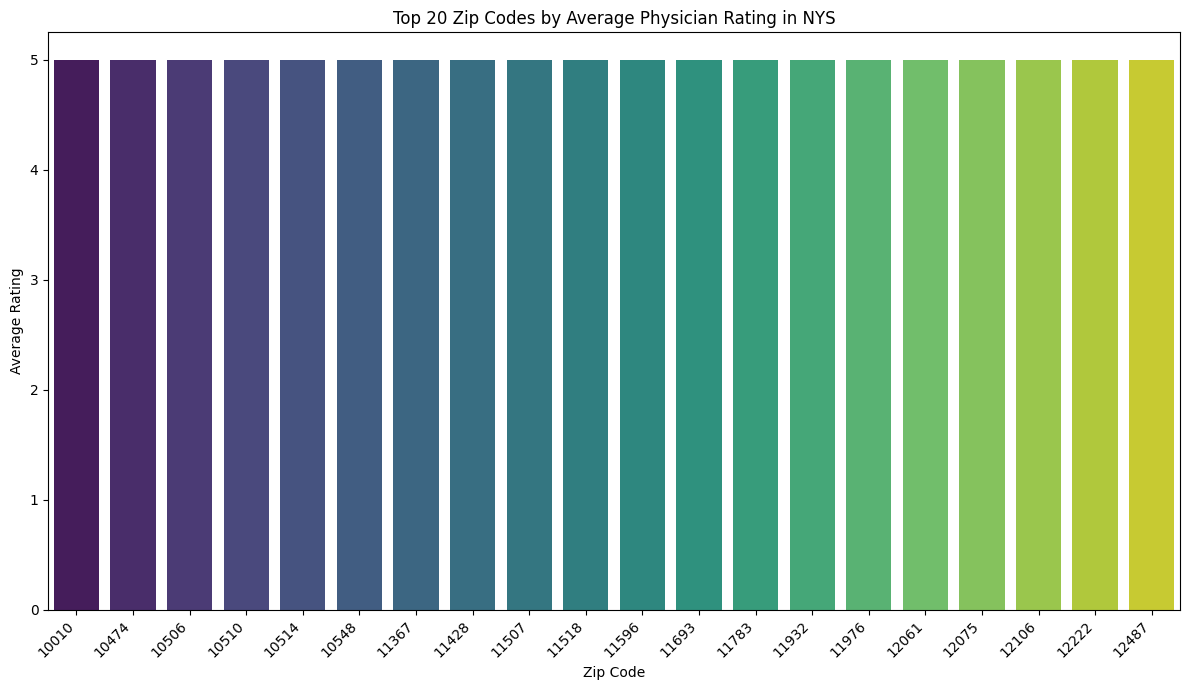

In [42]:


# Ensure 'rating' column is numeric, coercing errors to NaN
df_ny['rating'] = pd.to_numeric(df_ny['rating'], errors='coerce')

# Group by zip code and calculate the mean rating, then sort and get the top 20
top_20_zip_codes_by_rating = df_ny.groupby('zip_code')['rating'].mean().nlargest(20).sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x=top_20_zip_codes_by_rating.index.astype(str), y=top_20_zip_codes_by_rating.values, hue=top_20_zip_codes_by_rating.index.astype(str), palette='viridis', legend=False)
plt.title('Top 20 Zip Codes by Average Physician Rating in NYS')
plt.xlabel('Zip Code')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

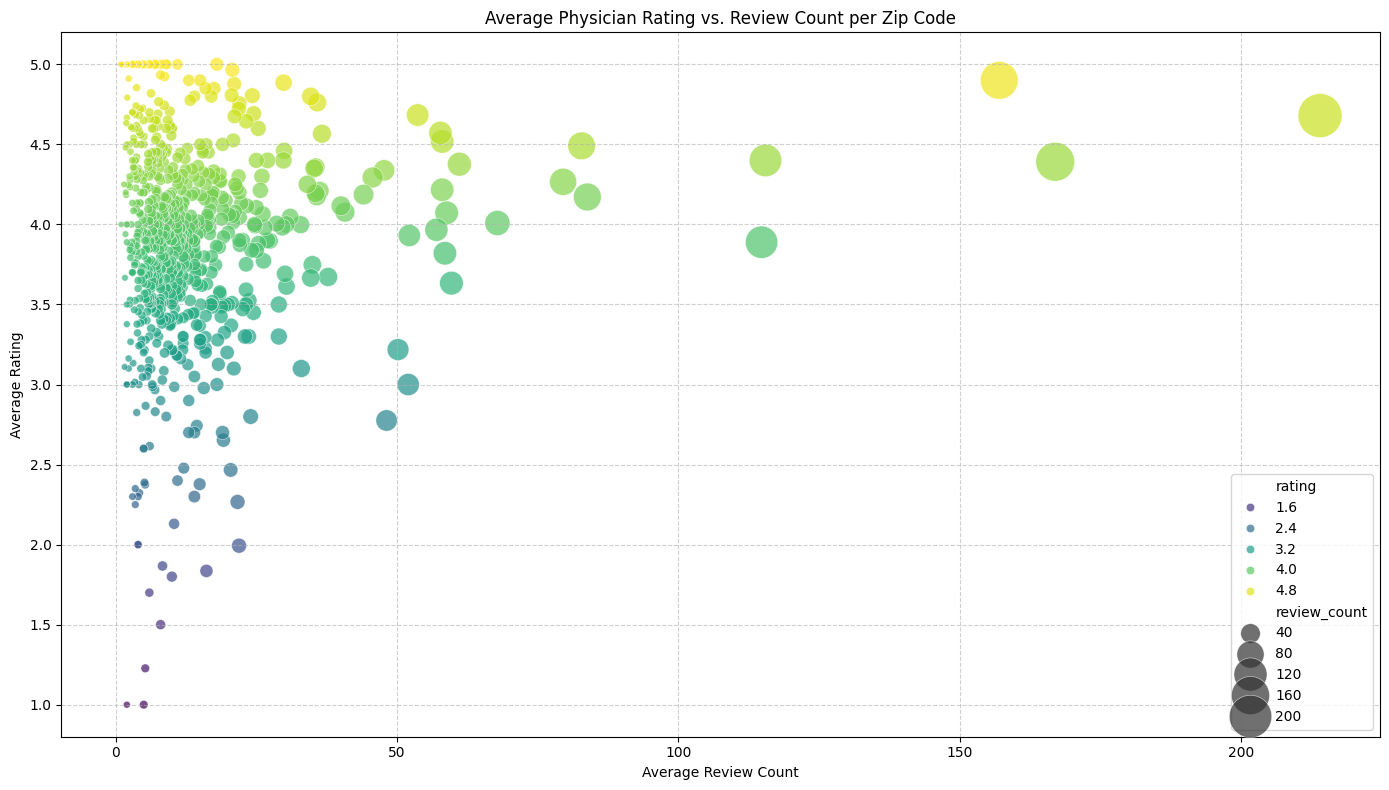

In [43]:


# Ensure highest_rated is clean for plotting by dropping rows with NaN values in rating or review_count
plot_data = highest_rated.dropna(subset=['rating', 'review_count'])

plt.figure(figsize=(14, 8))
sns.scatterplot(data=plot_data, x='review_count', y='rating', hue='rating', size='review_count', sizes=(20, 1000), palette='viridis',  alpha=0.7)
plt.title('Average Physician Rating vs. Review Count per Zip Code')
plt.xlabel('Average Review Count')
plt.ylabel('Average Rating')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
#scatter plot for zips got rating top 50 - Jerrod
sns.regplot(x="rating",y="zip_code", data=df, ci=None)

In [ ]:
df['rating'] = df['rating'].replace('NA', np.nan).astype(float)
#Creating histogram based on rating - Jerrod
df.hist(column="rating",legend=True, bins=20,orientation='horizontal');

In [ ]:
# bar chart of specialties - cat

top_10_specialties = specialty_counts_tele.head(10)

# x-axis: specialty names
categories = top_10_specialties.index

# y-axis: number of doctors
values = top_10_specialties.values
plt.figure(figsize=(12, 6))
plt.bar(categories, values)
plt.title('Top 10 Specialties Offering Telehealth')
plt.ylabel('Number of Doctors')
plt.xlabel('Specialty')


plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


NameError: name 'specialty_counts_tele' is not defined

# **Which doctors offer telehealth vs which don't**

In [ ]:
#creating bar-chart to showcase who offers telehealth and who doesn't -cat
tele_counts = df['offers_telehealth'].value_counts()

#x-axis
categories = ['Offers Telehealth', 'Does NOT Offer Telehealth']
values = [tele_counts[True], tele_counts[False]]
plt.bar(categories, values)

plt.title('Comparison of Telehealth Availability')
plt.ylabel('Number of Doctors')
plt.xlabel('Telehealth Status')

# Rotate x labels if needed
plt.xticks(rotation=0)
plt.show()


## Insights


## References

[Extracting strings from integers](https://stackoverflow.com/questions/56672613/separate-string-from-numeric-in-single-pandas-dataframe-column-and-create-two-ne)

[How To Remove Characters From A Pandas Dataframe In Python
](https://youtu.be/5wSIIjpdJ1k?si=YUNLVH1XKVBUsmzl)

[Aggregation / Groupby](https://youtu.be/VRmXto2YA2I?si=WYQz1dk3ouRvOp0a)

[Runestone Academy](https://runestone.academy/ns/books/published/CIS9650-Vaghefi-Fall2025/index.html)

## Appendix